In [372]:
import pandas as pd
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from ase.visualize.plot import plot_atoms

In [373]:
def print_atom_structure(structure):
    ase_atoms = AseAtomsAdaptor.get_atoms(structure)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)

In [374]:
energyForS = 2.693
energyForMo = 7.097

In [375]:
class function_calc:
    def V_z_16_V_z_16(self, x1):
        
        # constant
        
        return  0 - 1/(15+2*x1)
    
    def V_z_42_V_z_42(self, x1):
        
        #0
        
        return (8 / ((np.cos(np.cos(x1)) * np.cos(np.cos(x1))) - (np.exp(x1))))
    
    def V_z_42_V_z_16(self, x1):
    
        return 0 + (((x1 * (np.cos(0.5) * ((np.cos(((0.5 * (4 * (x1 * (4 - x1)))) / x1)) * x1) / x1))) - x1) / ((np.exp(x1)) / x1))
    
    def Se_Se(self, x1):
    
        return 0 +   ((((5 / x1) * 7) - (2 * 9)) / (np.exp(8)))
    
    def Se_V_z_16(self, x1):
    
        return 0 +   (3 / ((x1 / (3 - x1)) - (8**2)))
    
    def Se_V_z_42(self, x1):
    
        return  0 +   (((x1 / np.cos(2)) / 2) / (np.exp((x1 + 1))))
    
    def W_W(self, x1):
    
        #0
        
        return (np.cos(((np.cos(2) * np.cos(2)) * x1)) / (x1 * ((np.exp(x1)) * x1)))
    
    def W_Se(self, x1):
    
        return 0 +   ((-1 - (3 / (x1 - (x1**2)))) / (8**2))
    
    def W_V_z_42(self, x1):
        
        #0
        
        return (np.cos((x1 - (np.cos(7) * np.cos(7)))) / ((np.exp(x1)) + -1))
    
    def W_V_z_16(self, x1):
        
        return 0 +   (((2 - x1) / (7**2)) / x1)
    
    def __call__(self, defect_type1, defect_type2, distance, debug=False):
        all_funcs = [
            'Se_Se', # 0
            'Se_V_z_16', # 1
            'Se_V_z_42', # 2
            'V_z_16_V_z_16', # 3
            'V_z_42_V_z_16', # 4
            'V_z_42_V_z_42', # 5
            'W_Se', # 6
            'W_V_z_16', # 7
            'W_V_z_42', # 8
            'W_W' # 9
        ]
        defect_types = {
            'V_z_16': 0,
            'V_z_42': 1,
            'Se': 2,
            'W': 3,
        }
        call_matrix = [
            [3, 4, 1, 7], 
            [4, 5, 2, 8], 
            [1, 2, 0, 6], 
            [7, 8, 6, 9]
        ]
        func_num = call_matrix[defect_type1][defect_type2]
        func = getattr(self, all_funcs[func_num])
        if debug:
            print(func_num, distance, func(distance))
        return func(distance)

In [376]:
empty_pickle = pd.read_pickle('emptydata.pkl')
empty_pickle = empty_pickle.iloc[0]
structure = empty_pickle.initial_structure.copy()

In [377]:
from oper import Defect, DefectSet, TopBatch, RandomBatch, BatchOper, EvalFunction

In [378]:
def get_atom(structure, matrices, defect):
    defect_pos = matrices[defect.cords[0]][defect.cords[1]][defect.cords[2]][2]
    atom = structure[int(defect_pos)]
    return atom

In [379]:
def is_Mo(atom):
    return atom.species.as_dict()['Mo'] == 1.0

def is_S1(atom):
    return atom.frac_coords[2] ==  0.144826

def is_S2(atom):
    return atom.frac_coords[2] == 0.355174

In [380]:
def get_atom_id(atom):
    if is_S1(atom):
        return 0
    if is_Mo(atom):
        return 1
    if is_S2(atom):
        return 2
    raise ValueError(f"atom {atom} is not defined")

atom_types = [0, 1, 2]

In [381]:
def get_matrices_MoS2(structure):
    matrices = [[], [], []]
    elements = [[], [], []]
    for idx, atom in enumerate(structure):
        matrices[get_atom_id(atom)].append([atom.frac_coords[0], atom.frac_coords[1], idx])
    for matrix in matrices:
        matrix.sort()
    matrices = np.array(matrices).reshape(3, 8, 8, 3)
    return matrices

In [382]:
matrices = get_matrices_MoS2(structure)

In [383]:
def calc_distance(atom1, atom2):
    x = (atom1.coords[0] - atom2.coords[0]) ** 2
    y = (atom1.coords[1] - atom2.coords[1]) ** 2
    z = (atom1.coords[2] - atom2.coords[2]) ** 2
    distance = math.sqrt(x + y + z)
    return distance

In [384]:
def get_energy(structure, matrices, defect_set, function_set, debug=False):
    energy = 0
    for defect1, defect2, in itertools.combinations_with_replacement(list(defect_set), 2):
        atom1 = get_atom(structure, matrices, defect1)
        atom2 = get_atom(structure, matrices, defect2)
        if defect1 == defect2:
            continue
        distance = calc_distance(atom1, atom2)
        energy += function_set(defect1.type, defect2.type, distance, debug)
    return energy

In [385]:
function_set = function_calc()

In [386]:
eval_function = EvalFunction(get_energy, structure, matrices, function_set)

In [387]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [388]:
def possible_moves(defect, max_range=1):
    if defect.type == 0 or defect.type == 2:
        return [0, 2], list(range(-max_range, max_range + 1)), list(range(-max_range, max_range + 1))
    if defect.type == 1 or defect.type == 3:
        return [1], list(range(-max_range, max_range + 1)), list(range(-max_range, max_range + 1))

In [389]:
def get_possible_positions(structure, matrices, defect, defect_set, max_range=1):
    possible_positions = []
    for move in itertools.product(*possible_moves(defect, max_range)):
        position = [move[0], defect.cords[1] + move[1], defect.cords[2] + move[2]]
        if not 0 <= position[1] < matrices[position[0]].shape[0]:
            continue
        if not 0 <= position[2] < matrices[position[0]].shape[1]:
            continue
        if Defect(cords=tuple(position)) in defect_set:
            continue
        possible_positions.append(position)
    return possible_positions

In [390]:
import random


def upd_defect_set(structure, matrices, defect_set, max_range=1):
    random_defect = random.sample(defect_set.defect_set, 1)[0]
    defect_set = defect_set.copy()
    defect_set.remove_defect(random_defect)
    possible_positions = get_possible_positions(structure, matrices, random_defect, defect_set, max_range)
    new_sets = []
    for position in possible_positions:
        new_set = defect_set.copy()
        new_set.add_defect(Defect(type=random_defect.type, cords=tuple(position)))
        new_sets.append(new_set)
    return new_sets

In [391]:
target=0

In [392]:
def random_position(defect_type):
    layer = 100
    if defect_type == 0 or defect_type == 2:
        layer = random.choice([0, 2])
    if defect_type == 1 or defect_type == 3:
        layer = 1
        
    x = random.choice(range(matrices[layer].shape[0]))
    y = random.choice(range(matrices[layer].shape[1]))
    return layer, x, y

In [393]:
def random_defects(empty_set, defects):
    new_set = empty_set.copy()
    for defect_type in defects:
        for i in range(defects[defect_type]):
            defect = Defect(defect_type, random_position(defect_type))
            while defect in new_set:
                defect = Defect(defect_type, random_position(defect_type))
            new_set.add_defect(defect)
    return new_set

In [394]:
def mutate(defect_set):
    random_defect = random.sample(defect_set.defect_set, 1)[0]
    defect_set = defect_set.copy()
    defect_set.remove_defect(random_defect)
    possible_positions = get_possible_positions(structure, matrices, random_defect, defect_set, 1)
    position = random.choice(possible_positions)
    new_defect = Defect(type=random_defect.type, cords=tuple(position))
    defect_set.add_defect(new_defect)
    return defect_set

In [395]:
def step_optimize(structure, matrices, batch_op, max_range=1):
    new_sets = []
    for defect_set in batch_op:
        new_sets.extend(upd_defect_set(structure, matrices, defect_set, max_range))
    batch_op.process_members(new_sets)
    for i in range(5):
        batch_op[2].mutate(mutate)
    energies = []
    for defect_set in batch_op:
        energies.append(defect_set.get_energy())
    return np.mean(energies)

In [396]:
def create_printable_structure_MoS2(structure, defects):
    matrices = get_matrices_MoS2(structure)
    ans = structure.copy()
    to_delete = []
    for defect in defects:
        defect_id = int(matrices[defect.cords[0]][defect.cords[1]][defect.cords[2]][2])
        if defect.type == 0 or defect.type == 1:
            to_delete.append(defect_id)
        if defect.type == 2:
            ans.replace(defect_id, Element('Se'))
        if defect.type == 3:
            ans.replace(defect_id, Element('W'))
    ans.remove_sites(to_delete)
    return ans

In [397]:
batch_op = BatchOper([TopBatch(20), RandomBatch(7), TopBatch(15)], target_energy=-1000)
empty_set = DefectSet(eval_function)
defects = {
    0: 2,
    1: 2,
    2: 2,
    3: 2,
}
initial_set = random_defects(empty_set, defects)
batch_op.process_members([initial_set])

In [398]:
energies = []
for i in range(200):
    energies.append(step_optimize(structure, matrices, batch_op))

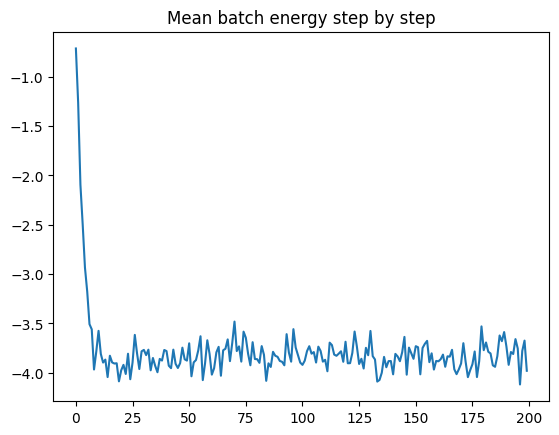

In [399]:
plt.plot(np.array(energies))
plt.title("Mean batch energy step by step")
plt.show()

In [400]:
best_set = batch_op[0].members[0]

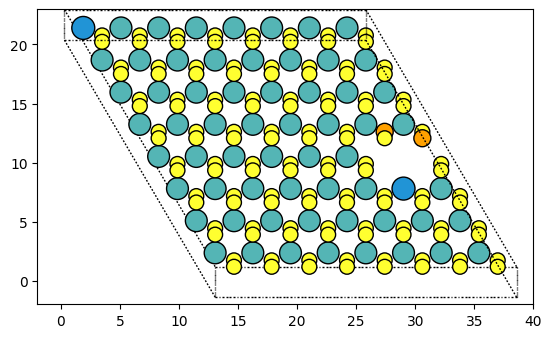

In [401]:
print_atom_structure(create_printable_structure_MoS2(structure, best_set))

In [402]:
best_set.get_energy(debug=True)

2 2.4169336728972426 -0.09528679069913419
4 2.4169333360037606 -0.9781522312797009
8 3.190315614924915 -0.03725925810842543
8 27.81252746858245 -4.2924043448299977e-13
2 4.002459370980892 -0.03232286423633371
5 3.1903156999999993 -0.33329041871678666
4 2.4169333360037606 -0.9781522312797009
1 3.190315700000001 -0.03714559308515288
6 5.118378427272319 -0.013401267014833188
6 27.178406487912216 -0.015559116891182683
0 4.46917963279444 -0.0034111802772225225
2 4.002459777855278 -0.032322854370805634
1 4.46917963279444 -0.044748097818983694
7 2.416933616748325 -0.003520514284062943
7 29.684328816953595 -0.01903315065234447
1 4.469179632794441 -0.044748097818983694
4 2.416933672897242 -0.9781521819934399
3 3.1297687333919995 -0.047037711971034395
9 30.433672039913105 3.467487889056562e-17
6 5.118378294702802 -0.01340126688565559
8 3.190315657462459 -0.037259257362192044
7 2.4169336167483246 -0.00352051428406294
6 30.194266344953988 -0.015571823563191348
8 30.76629042811277 1.502593684011525

-4.892914139023716

In [403]:
def W_Se(x1):
    
        return 0 +   ((-1 - (3 / (x1 - (x1**2)))) / (8**2))

In [404]:
W_Se(0.999454)

-85.9141739593724

In [405]:
def Se_V_z_16(x1):

    return 0 +   (3 / ((x1 / (3 - x1)) - (8**2)))

In [406]:
Se_V_z_16(0)

-0.046875